In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

## Understanding the dataset

### Counting classes

In [2]:
data_dir = r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification'
classes = os.listdir(data_dir)
print(classes)

['metal', 'trash', 'paper', 'glass', 'plastic', 'cardboard']


So we're looking at a multiclass classification problem.

### Counting the number of images in each class

In [3]:
import os

total = 0

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/metal"))
file_count = len(files)
print("Metal count: " + str(file_count))
total += file_count

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/trash"))
file_count = len(files)
print("Trash count: " + str(file_count))
total += file_count

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/paper"))
file_count = len(files)
print("Paper count: " + str(file_count))
total += file_count

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/glass"))
file_count = len(files)
print("Glass count: " + str(file_count))
total += file_count

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/plastic"))
file_count = len(files)
print("Plastic count: " + str(file_count))
total += file_count

_, _, files = next(os.walk("/mnt/sdb/aditi/archive/garbage classification/Garbage classification/cardboard"))
file_count = len(files)
print("Cardboard count: " + str(file_count))
total += file_count

print("Total: "+str(total))


Metal count: 410
Trash count: 137
Paper count: 594
Glass count: 501
Plastic count: 482
Cardboard count: 403
Total: 2527


This means that the classes are not balanced, in the sense that the model won't have access to equal number of images for each class./
The class with the least examples is Trash(137) and the class with the most examples is Paper(593). 
The ratio between these classes is: 1 : 4.32 which according to this link https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data qualifies as **moderate imbalance**.\
The link suggests that we first train on the true distribution of data and look at the classifications before we look at balancing techniques.

### Understanding the images

In [4]:
images = []

from PIL import Image

images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/glass/glass1.jpg').convert("RGB"))
images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/cardboard/cardboard1.jpg').convert("RGB"))
images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/metal/metal1.jpg').convert("RGB"))
images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/paper/paper1.jpg').convert("RGB"))
images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/plastic/plastic1.jpg').convert("RGB"))
images.append(Image.open(r'/mnt/sdb/aditi/archive/garbage classification/Garbage classification/trash/trash1.jpg').convert("RGB"))
    
for image in images:
    print(image.size)

(512, 384)
(512, 384)
(512, 384)
(512, 384)
(512, 384)
(512, 384)


The image size is 512x384 but this may be too much for the GPU to handle. So we rescale the images to 224x224. Much later I figured out that changing the aspect ratio of the images by rescaling can cause informatioon loss. 

In [5]:
transform = transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

batch_size = 4


Normalization helps get data within a range and reduces the skewness which helps learn faster and better
In the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model. We'd like in this process for each feature to have a similar range so that our gradients don't go out of control. So we do the third transformation. We use those values because those are the values used in the ImageNet dataset - The images in our dataset are not color filtered, contrast adjusted, uncommon lighting and do not contain an "un-natural subject" (medical images, satellite imagery, hand drawings, etc.) just like in ImageNet

Looking at the new image 'sizes', 3 represents the number of color channels in the image. In this case, the image has 3 color channels (red, green, and blue), so the first dimension of the tensor is 3.
(224, 224) represent the height and width of the image, respectively

In [6]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir, transform = transform)

### To ensure repreducibility

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

### Creating our train, test and validation dataloaders in a 80,10,10 (%) split

In [8]:
from torch.utils.data import random_split
print(len(dataset))
trainset, valset, testset = random_split(dataset, [2020, 254, 253])

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=False, num_workers=2)

2527


### Visualizing the images in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


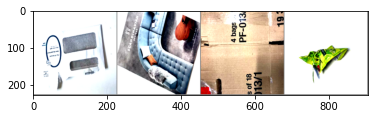

glass glass metal plastic


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

We see that according to our transformation, the images have been correctly resized.

## Special Functions

In [10]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [11]:
from sklearn.metrics import f1_score

from tqdm import tqdm
def train(model, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, criterion):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(6))
    class_total = list(0. for i in range(6))
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_dataloader.dataset))
    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(6):
        print(f"Accuracy of class {classes[i]}: {100*class_correct[i]/class_total[i]}")
    return epoch_loss, epoch_acc

def training_loop(model, criterion, optimizer, epochs):
    # start the training
    # lists to keep track of losses and accuracies
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    early_stopping = EarlyStopping(tolerance=3, min_delta=10)
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print('\n')
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)
        
        ## EARLY STOPPING
        early_stopping(train_epoch_loss, valid_epoch_loss)
        if early_stopping.early_stop:
            print("We are at epoch:", i)
            break
            
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # loss plots
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('TRAINING COMPLETE')

In [12]:
## This function evaluates the model on the test dataset, 
## returns accuracy and f1-score of the model
def test(model):
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct // total
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Accuracy of the network on the test images: {accuracy} %')
    print(f'F1-score of the network on the test images: {f1}')

In [13]:
def class_accuracy(model):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [14]:
## Given explore_class in [0,1,2,3,4,5], understand whether explore_class was misclassified
## understand what the misclassification were
def explore(model, explore_class):
    classifications = {
        classes[0]:0,
        classes[1]:0,
        classes[2]:0,
        classes[3]:0,
        classes[4]:0,
        classes[5]:0
    }
    # again no gradients needed
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == explore_class:
                    classifications[classes[prediction]] += 1
                        
    plt.bar(classifications.keys(), classifications.values(), color ='maroon', width = 0.4)
    plt.xlabel("Predictions for: "+ str(classes[explore_class]))
    plt.ylabel("Numbers")
    plt.show()
    

## Model 

### Model building process
1. Try sample image classification model from PyTorch website.
2. Iteratively build on sample model to see if accuracy can be improved. 
3. Implement the 'tried and tested' VGG-11 architecture

### Let's try the same image classification model from the Pytorch image classification tutorial
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 56 * 56, 1296)
        self.fc2 = nn.Linear(1296, 216)
        self.fc3 = nn.Linear(216, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=401408, out_features=1296, bias=True)
  (fc2): Linear(in_features=1296, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=6, bias=True)
)

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.54it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 160.66it/s]



Accuracy of class metal: 56.41025641025641
Accuracy of class trash: 76.36363636363636
Accuracy of class paper: 12.820512820512821
Accuracy of class glass: 37.096774193548384
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 0.0


Training loss: 1.486, training acc: 40.248
Validation loss: 1.318, validation acc: 47.244
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.48it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 160.81it/s]



Accuracy of class metal: 51.282051282051285
Accuracy of class trash: 30.90909090909091
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 66.12903225806451
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 11.764705882352942


Training loss: 1.198, training acc: 53.812
Validation loss: 1.193, validation acc: 53.543
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.45it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 152.73it/s]



Accuracy of class metal: 53.84615384615385
Accuracy of class trash: 47.27272727272727
Accuracy of class paper: 56.41025641025641
Accuracy of class glass: 93.54838709677419
Accuracy of class plastic: 64.28571428571429
Accuracy of class cardboard: 47.05882352941177


Training loss: 0.962, training acc: 64.653
Validation loss: 1.054, validation acc: 63.780
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.49it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.99it/s]




Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 50.90909090909091
Accuracy of class paper: 28.205128205128204
Accuracy of class glass: 98.38709677419355
Accuracy of class plastic: 59.523809523809526
Accuracy of class cardboard: 64.70588235294117


Training loss: 0.777, training acc: 71.436
Validation loss: 1.049, validation acc: 64.173
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.41it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.35it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 67.27272727272727
Accuracy of class paper: 69.23076923076923
Accuracy of class glass: 87.09677419354838
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.607, training acc: 78.218
Validation loss: 0.986, validation acc: 70.472
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.45it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.85it/s]



Accuracy of class metal: 74.35897435897436
Accuracy of class trash: 78.18181818181819
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 82.25806451612904
Accuracy of class plastic: 45.23809523809524
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.390, training acc: 86.535
Validation loss: 0.979, validation acc: 68.504
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.44it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.04it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 72.72727272727273
Accuracy of class paper: 33.333333333333336
Accuracy of class glass: 80.64516129032258
Accuracy of class plastic: 71.42857142857143
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.273, training acc: 90.594
Validation loss: 1.283, validation acc: 64.961
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.42it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.74it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 69.0909090909091
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 88.70967741935483
Accuracy of class plastic: 54.76190476190476
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.162, training acc: 95.099
Validation loss: 1.243, validation acc: 68.504
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.38it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.47it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 61.81818181818182
Accuracy of class paper: 64.1025641025641
Accuracy of class glass: 83.87096774193549
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 64.70588235294117


Training loss: 0.148, training acc: 94.505
Validation loss: 1.143, validation acc: 70.472
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:19<00:00, 25.45it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.17it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 61.81818181818182
Accuracy of class paper: 56.41025641025641
Accuracy of class glass: 79.03225806451613
Accuracy of class plastic: 57.142857142857146
Accuracy of class cardboard: 47.05882352941177


Training loss: 0.079, training acc: 97.475
Validation loss: 1.533, validation acc: 64.961
--------------------------------------------------


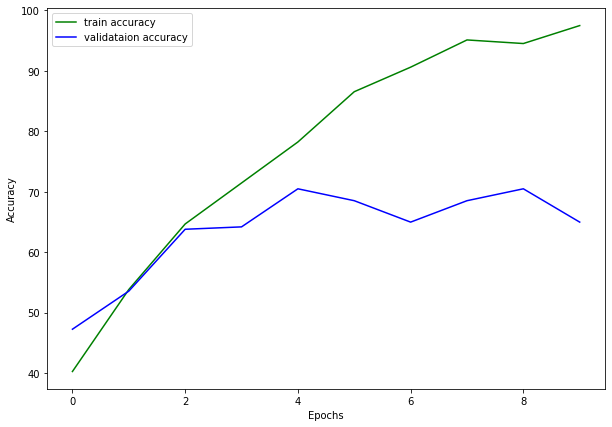

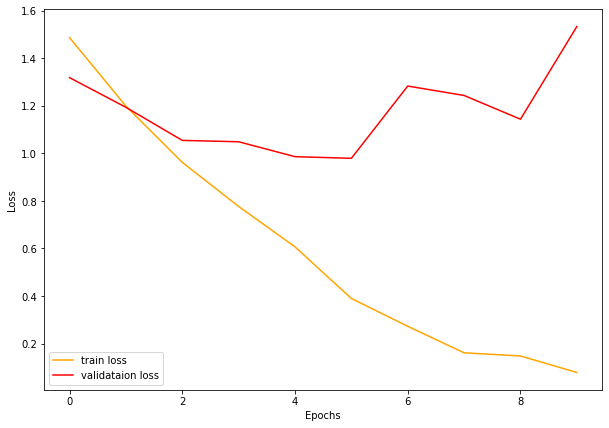

TRAINING COMPLETE


In [26]:
training_loop(net, criterion, optimizer, 10)

In [27]:
PATH = './garbage_net.pth'
torch.save(net.state_dict(), PATH)

In [28]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
net.cuda()
test(net)

Accuracy of the network on the test images: 60 %
F1-score of the network on the test images: 0.6020185757907471


In [30]:
net.cuda()
class_accuracy(net)

Accuracy for class: metal is 81.6 %
Accuracy for class: trash is 52.0 %
Accuracy for class: paper is 53.2 %
Accuracy for class: glass is 72.7 %
Accuracy for class: plastic is 48.9 %
Accuracy for class: cardboard is 43.8 %


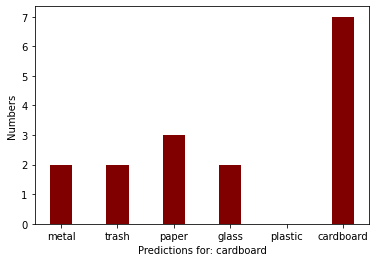

In [31]:
explore(net, 5)

In [32]:
del Net
del net

Observations
1. We get a an overall accuracy of 60%. All classes do significantly better than chance.
2. Cardboard classification accuracy is low.
3. Trash classification accuracy is as bad as 3 other classes. No need to change distribution.
4. Looking at the results of the explore function, cardboard was most commonly misclassified as paper.
5. Looking at the training loss and validation loss curves, there is evidence of overfitting.

## Let's try with an improved CNN

We'll use LeakyReLu instead of ReLu and we'll set **inplace = True** to save some memory and training time. This claim is supported by https://github.com/pytorch/vision/issues/807 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class ImpNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 1296)
        self.fc2 = nn.Linear(1296, 216)
        self.fc3 = nn.Linear(216, 6)

    def forward(self, x):
        
        x = self.pool(F.leaky_relu(self.conv1(x), inplace=True))
        x = self.pool(F.leaky_relu(self.conv2(x), inplace=True))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)
        x = self.fc3(x)
        return x
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
impnet = ImpNet()
impnet.to(device)

ImpNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=401408, out_features=1296, bias=True)
  (fc2): Linear(in_features=1296, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=6, bias=True)
)

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(impnet.parameters(), lr=0.001, momentum=0.9)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 29.86it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.12it/s]



Accuracy of class metal: 56.41025641025641
Accuracy of class trash: 49.09090909090909
Accuracy of class paper: 20.512820512820515
Accuracy of class glass: 77.41935483870968
Accuracy of class plastic: 59.523809523809526
Accuracy of class cardboard: 11.764705882352942


Training loss: 1.487, training acc: 40.099
Validation loss: 1.268, validation acc: 51.969
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:15<00:00, 31.66it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.82it/s]




Accuracy of class metal: 51.282051282051285
Accuracy of class trash: 45.45454545454545
Accuracy of class paper: 15.384615384615385
Accuracy of class glass: 80.64516129032258
Accuracy of class plastic: 73.80952380952381
Accuracy of class cardboard: 52.94117647058823


Training loss: 1.147, training acc: 56.634
Validation loss: 1.210, validation acc: 55.512
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:15<00:00, 31.65it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.92it/s]




Accuracy of class metal: 74.35897435897436
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 28.205128205128204
Accuracy of class glass: 100.0
Accuracy of class plastic: 54.76190476190476
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.972, training acc: 64.257
Validation loss: 0.955, validation acc: 66.929
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.51it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.07it/s]



Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 53.84615384615385
Accuracy of class glass: 91.93548387096774
Accuracy of class plastic: 71.42857142857143
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.792, training acc: 72.030
Validation loss: 0.866, validation acc: 70.079
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.54it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 156.32it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 89.0909090909091
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 79.03225806451613
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.636, training acc: 76.634
Validation loss: 0.835, validation acc: 70.866
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.48it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.17it/s]



Accuracy of class metal: 76.92307692307692
Accuracy of class trash: 50.90909090909091
Accuracy of class paper: 61.53846153846154
Accuracy of class glass: 79.03225806451613
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 47.05882352941177


Training loss: 0.392, training acc: 86.485
Validation loss: 0.988, validation acc: 68.110
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.54it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.04it/s]



Accuracy of class metal: 74.35897435897436
Accuracy of class trash: 78.18181818181819
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 72.58064516129032
Accuracy of class plastic: 35.714285714285715
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.267, training acc: 91.931
Validation loss: 1.171, validation acc: 62.992
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:15<00:00, 31.60it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.36it/s]



Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 67.27272727272727
Accuracy of class paper: 53.84615384615385
Accuracy of class glass: 85.48387096774194
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.191, training acc: 93.663
Validation loss: 1.075, validation acc: 71.260
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.53it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 155.45it/s]



Accuracy of class metal: 84.61538461538461
Accuracy of class trash: 76.36363636363636
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 85.48387096774194
Accuracy of class plastic: 47.61904761904762
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.101, training acc: 96.980
Validation loss: 1.327, validation acc: 70.079
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.52it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 159.12it/s]




Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 61.81818181818182
Accuracy of class paper: 46.15384615384615
Accuracy of class glass: 77.41935483870968
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 58.8235294117647


Training loss: 0.069, training acc: 97.970
Validation loss: 1.303, validation acc: 69.291
--------------------------------------------------


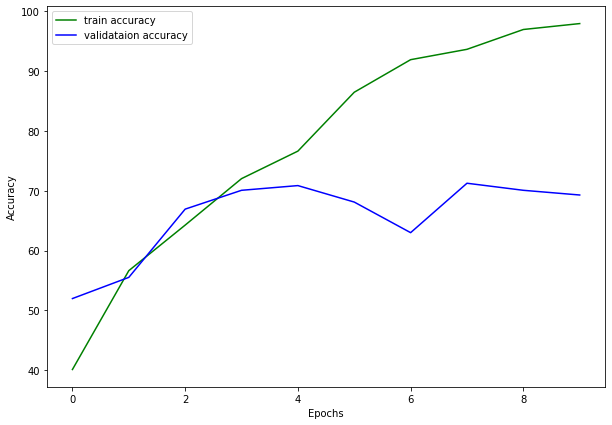

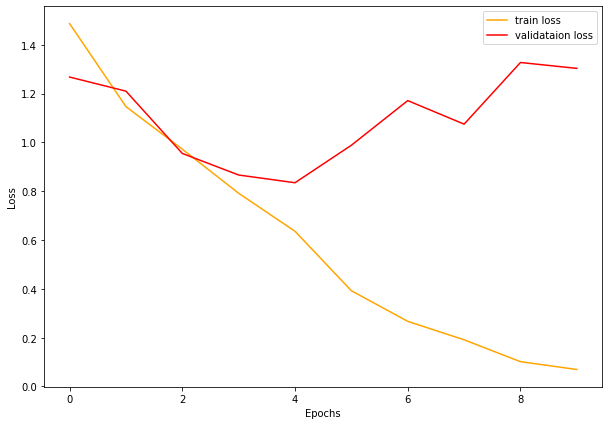

TRAINING COMPLETE


In [17]:
training_loop(impnet, criterion, optimizer, 10)

In [18]:
PATH = './garbage_impnet.pth'
torch.save(impnet.state_dict(), PATH)

In [19]:
impnet = ImpNet()
impnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
impnet.cuda()
test(impnet)

Accuracy of the network on the test images: 67 %
F1-score of the network on the test images: 0.6728997586605809


In [21]:
impnet.cuda()
class_accuracy(impnet)

Accuracy for class: metal is 84.2 %
Accuracy for class: trash is 60.0 %
Accuracy for class: paper is 53.2 %
Accuracy for class: glass is 80.0 %
Accuracy for class: plastic is 70.2 %
Accuracy for class: cardboard is 43.8 %


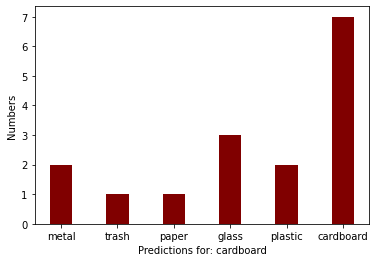

In [22]:
explore(impnet, 5)

In [ ]:
del ImpNet
del impnet

Observations
1. We get a an overall accuracy of 67%. However, cardboard classification accuracy is still the lowest.
2. Looking at the results of the explore function, cardboard was most commonly misclassified as glass.
3. Looking at the training loss and validation loss curves, there is evidence of overfitting.

## Let's try dropout regularization with this model

In class we learnt that, dropout regularization is a technique commonly used in neural networks to improve accuracy and prevent overfitting. It works by randomly dropping out (setting to zero) a certain percentage of the nodes or connections in a neural network during training.

We use the guidance of the papers mentioned in this link to set dropout values. https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolution-neural-network \


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class DropNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 1296)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1296, 216)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(216, 6)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), inplace=True))
        x = self.pool(F.leaky_relu(self.conv2(x), inplace=True))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dropnet = DropNet()
dropnet.to(device)

DropNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=401408, out_features=1296, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1296, out_features=216, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=216, out_features=6, bias=True)
)

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dropnet.parameters(), lr=0.001, momentum=0.9)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.56it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.94it/s]




Accuracy of class metal: 61.53846153846154
Accuracy of class trash: 29.09090909090909
Accuracy of class paper: 23.076923076923077
Accuracy of class glass: 56.45161290322581
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 0.0


Training loss: 1.568, training acc: 36.287
Validation loss: 1.396, validation acc: 46.457
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.51it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 154.45it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 49.09090909090909
Accuracy of class paper: 25.641025641025642
Accuracy of class glass: 95.16129032258064
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 0.0


Training loss: 1.322, training acc: 48.267
Validation loss: 1.202, validation acc: 59.449
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.54it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.11it/s]



Accuracy of class metal: 58.97435897435897
Accuracy of class trash: 30.90909090909091
Accuracy of class paper: 71.7948717948718
Accuracy of class glass: 87.09677419354838
Accuracy of class plastic: 54.76190476190476
Accuracy of class cardboard: 17.647058823529413


Training loss: 1.139, training acc: 58.267
Validation loss: 1.139, validation acc: 58.268
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:15<00:00, 31.60it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.78it/s]




Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 72.72727272727273
Accuracy of class paper: 53.84615384615385
Accuracy of class glass: 83.87096774193549
Accuracy of class plastic: 47.61904761904762
Accuracy of class cardboard: 11.764705882352942


Training loss: 0.989, training acc: 64.505
Validation loss: 0.930, validation acc: 65.748
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.53it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 156.69it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 70.9090909090909
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 91.93548387096774
Accuracy of class plastic: 59.523809523809526
Accuracy of class cardboard: 64.70588235294117


Training loss: 0.825, training acc: 70.248
Validation loss: 0.829, validation acc: 72.047
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.50it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.67it/s]




Accuracy of class metal: 64.1025641025641
Accuracy of class trash: 67.27272727272727
Accuracy of class paper: 66.66666666666667
Accuracy of class glass: 88.70967741935483
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.659, training acc: 76.782
Validation loss: 0.907, validation acc: 70.472
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.40it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 160.89it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 72.72727272727273
Accuracy of class paper: 71.7948717948718
Accuracy of class glass: 82.25806451612904
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.462, training acc: 83.267
Validation loss: 0.997, validation acc: 72.835
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.45it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.26it/s]




Accuracy of class metal: 84.61538461538461
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 46.15384615384615
Accuracy of class glass: 83.87096774193549
Accuracy of class plastic: 61.904761904761905
Accuracy of class cardboard: 47.05882352941177


Training loss: 0.330, training acc: 90.050
Validation loss: 0.981, validation acc: 68.110
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.43it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 156.14it/s]



Accuracy of class metal: 61.53846153846154
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 56.41025641025641
Accuracy of class glass: 87.09677419354838
Accuracy of class plastic: 52.38095238095238
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.251, training acc: 92.376
Validation loss: 1.293, validation acc: 65.748
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.52it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.32it/s]




Accuracy of class metal: 64.1025641025641
Accuracy of class trash: 69.0909090909091
Accuracy of class paper: 61.53846153846154
Accuracy of class glass: 79.03225806451613
Accuracy of class plastic: 64.28571428571429
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.182, training acc: 94.554
Validation loss: 1.191, validation acc: 66.535
--------------------------------------------------


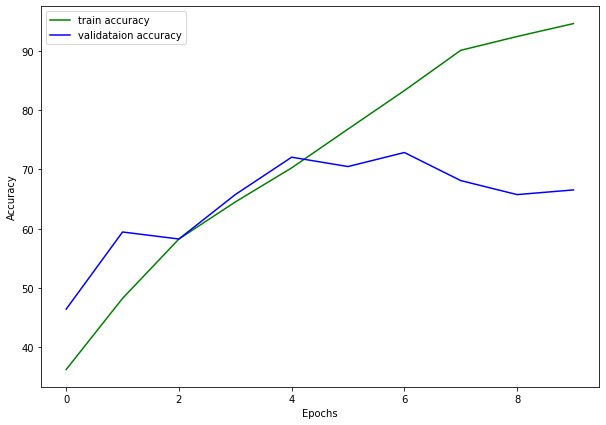

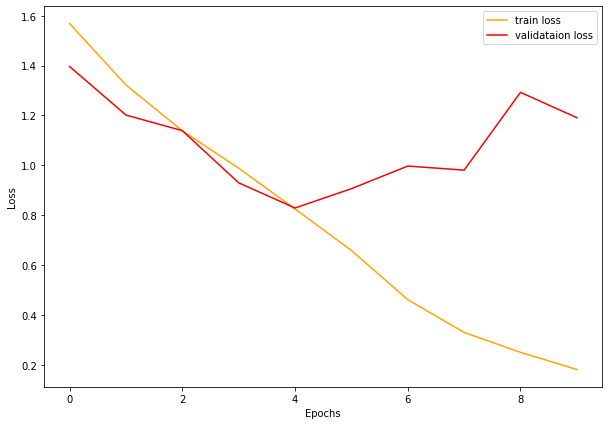

TRAINING COMPLETE


In [35]:
training_loop(dropnet, criterion, optimizer, 10)

In [36]:
PATH = './garbage_dropnet.pth'
torch.save(dropnet.state_dict(), PATH)

In [37]:
dropnet = DropNet()
dropnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [38]:
dropnet.cuda()
test(dropnet)

Accuracy of the network on the test images: 63 %
F1-score of the network on the test images: 0.6362562291080066


In [39]:
dropnet.cuda()
class_accuracy(dropnet)

Accuracy for class: metal is 65.8 %
Accuracy for class: trash is 60.0 %
Accuracy for class: paper is 59.6 %
Accuracy for class: glass is 72.7 %
Accuracy for class: plastic is 66.0 %
Accuracy for class: cardboard is 25.0 %


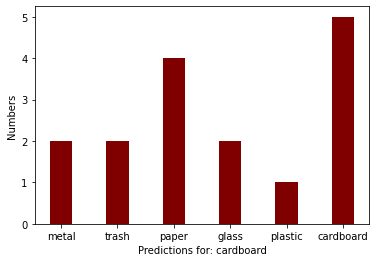

In [40]:
explore(dropnet, 5)

In [41]:
del dropnet
del DropNet

Observations
1. We get a an overall accuracy of 63%. 
2. Cardboard classification accuracy is low and is almost to comparable to chance.
3. Looking at the results of the explore function, cardboard was most commonly misclassified as paper.
3. Looking at the training loss and validation loss curves, there is evidence of overfitting.

Conclusions
1. The dropout value of 0.5 on the linear layers was far too aggressive - this is supplemented by the fact that the already low cardboard accuracy dropped even further - the dropout hampers the learning of such a simple model.

## Let's try to use dropout on the convolutional layers

For experimental purpose, we will build on the previous model to see how accuracy drops further on adding dropout on convolutional layer. The guidance for implementation comes from: https://stats.stackexchange.com/questions/147850/are-pooling-layers-added-before-or-after-dropout-layers#:~:text=Pooling%20usually%20operates%20separately%20on,operations%20like%20maxpooling%20or%20averaging.

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class CDropNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(128 * 56 * 56, 1296)
        self.fc2 = nn.Linear(1296, 216)
        self.fc3 = nn.Linear(216, 6)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x), inplace=True)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x), inplace=True)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cdropnet = CDropNet()
cdropnet.to(device)

CDropNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=401408, out_features=1296, bias=True)
  (fc2): Linear(in_features=1296, out_features=216, bias=True)
  (fc3): Linear(in_features=216, out_features=6, bias=True)
)

In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cdropnet.parameters(), lr=0.001, momentum=0.9)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.40it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 156.76it/s]



Accuracy of class metal: 64.1025641025641
Accuracy of class trash: 1.8181818181818181
Accuracy of class paper: 43.58974358974359
Accuracy of class glass: 70.96774193548387
Accuracy of class plastic: 76.19047619047619
Accuracy of class cardboard: 0.0


Training loss: 1.524, training acc: 36.584
Validation loss: 1.301, validation acc: 46.850
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.32it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 153.89it/s]



Accuracy of class metal: 74.35897435897436
Accuracy of class trash: 56.36363636363637
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 70.96774193548387
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 0.0


Training loss: 1.205, training acc: 55.099
Validation loss: 1.129, validation acc: 59.843
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.34it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.88it/s]



Accuracy of class metal: 61.53846153846154
Accuracy of class trash: 56.36363636363637
Accuracy of class paper: 56.41025641025641
Accuracy of class glass: 87.09677419354838
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 17.647058823529413


Training loss: 1.049, training acc: 61.386
Validation loss: 0.953, validation acc: 64.173
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.41it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 156.33it/s]



Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 50.90909090909091
Accuracy of class paper: 79.48717948717949
Accuracy of class glass: 91.93548387096774
Accuracy of class plastic: 52.38095238095238
Accuracy of class cardboard: 29.41176470588235


Training loss: 0.883, training acc: 67.723
Validation loss: 0.924, validation acc: 66.929
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.31it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.41it/s]




Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 74.54545454545455
Accuracy of class paper: 66.66666666666667
Accuracy of class glass: 88.70967741935483
Accuracy of class plastic: 45.23809523809524
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.671, training acc: 75.693
Validation loss: 0.898, validation acc: 70.866
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.32it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.51it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 76.36363636363636
Accuracy of class paper: 51.282051282051285
Accuracy of class glass: 69.35483870967742
Accuracy of class plastic: 71.42857142857143
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.543, training acc: 80.941
Validation loss: 1.106, validation acc: 66.142
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.29it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.58it/s]



Accuracy of class metal: 38.46153846153846
Accuracy of class trash: 72.72727272727273
Accuracy of class paper: 53.84615384615385
Accuracy of class glass: 70.96774193548387
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 47.05882352941177


Training loss: 0.383, training acc: 86.832
Validation loss: 1.145, validation acc: 61.417
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.33it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.38it/s]



Accuracy of class metal: 58.97435897435897
Accuracy of class trash: 54.54545454545455
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 77.41935483870968
Accuracy of class plastic: 73.80952380952381
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.245, training acc: 92.178
Validation loss: 1.265, validation acc: 62.992
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.34it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 158.35it/s]



Accuracy of class metal: 56.41025641025641
Accuracy of class trash: 61.81818181818182
Accuracy of class paper: 71.7948717948718
Accuracy of class glass: 77.41935483870968
Accuracy of class plastic: 64.28571428571429
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.153, training acc: 95.297
Validation loss: 1.248, validation acc: 65.354
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:16<00:00, 31.37it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 157.34it/s]



Accuracy of class metal: 66.66666666666667
Accuracy of class trash: 25.454545454545453
Accuracy of class paper: 43.58974358974359
Accuracy of class glass: 93.54838709677419
Accuracy of class plastic: 85.71428571428571
Accuracy of class cardboard: 52.94117647058823


Training loss: 0.085, training acc: 97.525
Validation loss: 1.803, validation acc: 62.992
--------------------------------------------------


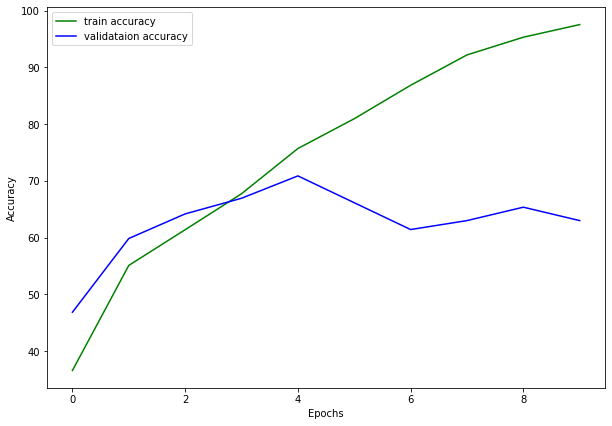

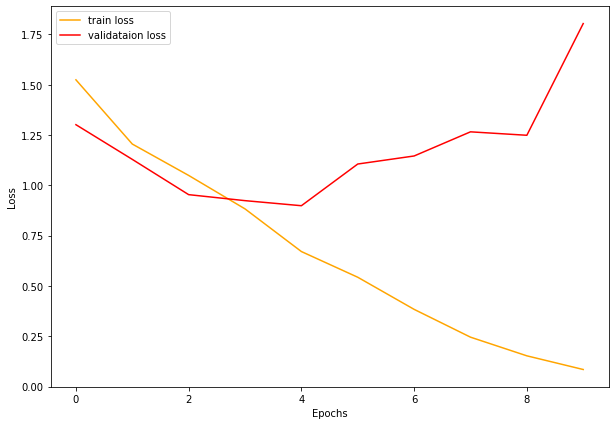

TRAINING COMPLETE


In [44]:
training_loop(cdropnet, criterion, optimizer, 10)

In [45]:
PATH = './garbage_cdnet.pth'
torch.save(cdropnet.state_dict(), PATH)

In [46]:
cdropnet = CDropNet()
cdropnet.load_state_dict(torch.load("./garbage_cdnet.pth"))

<All keys matched successfully>

In [47]:
cdropnet.cuda()
test(cdropnet)

Accuracy of the network on the test images: 62 %
F1-score of the network on the test images: 0.6049316891747808


In [48]:
cdropnet.cuda()
class_accuracy(cdropnet)

Accuracy for class: metal is 63.2 %
Accuracy for class: trash is 32.0 %
Accuracy for class: paper is 48.9 %
Accuracy for class: glass is 92.7 %
Accuracy for class: plastic is 74.5 %
Accuracy for class: cardboard is 56.2 %


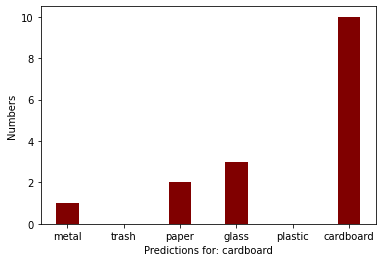

In [49]:
explore(cdropnet, 5)

In [50]:
del cdropnet
del CDropNet

Observations
1. We get a an overall accuracy of 62% - a dip from previous. Most classes do significantly better than chance.
2. Trash classification accuracy is low but cardboard classification accuracy is better.
3. Looking at the training loss and validation loss curves, there is evidence of overfitting.

Conclusions
1. The dropout on convolution layers further hampered model's learning

### Let's try with MLP
As an experiment, let's see how we would do without the convolutional layers.

In [51]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_fc = nn.Linear(3*224*224, 1024)
        self.hidden_fc = nn.Linear(1024, 256)
        self.output_fc = nn.Linear(256, 6)

    def forward(self, x):
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)                      # x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))                   # h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))                # h_2 = [batch size, 100]
        x = self.output_fc(h_2)                            # y_pred = [batch size, output dim]
        return x
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mlp = MLP()
mlp.to(device)

MLP(
  (input_fc): Linear(in_features=150528, out_features=1024, bias=True)
  (hidden_fc): Linear(in_features=1024, out_features=256, bias=True)
  (output_fc): Linear(in_features=256, out_features=6, bias=True)
)

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

[INFO]: Epoch 1 of 10
Training


100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.61it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 182.98it/s]



Accuracy of class metal: 56.41025641025641
Accuracy of class trash: 12.727272727272727
Accuracy of class paper: 10.256410256410257
Accuracy of class glass: 27.419354838709676
Accuracy of class plastic: 92.85714285714286
Accuracy of class cardboard: 11.764705882352942


Training loss: 1.595, training acc: 34.752
Validation loss: 1.558, validation acc: 35.827
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.62it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 186.30it/s]



Accuracy of class metal: 53.84615384615385
Accuracy of class trash: 50.90909090909091
Accuracy of class paper: 58.97435897435897
Accuracy of class glass: 27.419354838709676
Accuracy of class plastic: 0.0
Accuracy of class cardboard: 11.764705882352942


Training loss: 1.421, training acc: 44.901
Validation loss: 1.569, validation acc: 35.827
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 119.17it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 186.93it/s]



Accuracy of class metal: 46.15384615384615
Accuracy of class trash: 1.8181818181818181
Accuracy of class paper: 84.61538461538461
Accuracy of class glass: 62.903225806451616
Accuracy of class plastic: 45.23809523809524
Accuracy of class cardboard: 0.0


Training loss: 1.352, training acc: 47.178
Validation loss: 1.428, validation acc: 43.307
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.83it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 188.62it/s]



Accuracy of class metal: 41.02564102564103
Accuracy of class trash: 21.818181818181817
Accuracy of class paper: 41.02564102564103
Accuracy of class glass: 75.80645161290323
Accuracy of class plastic: 83.33333333333333
Accuracy of class cardboard: 23.529411764705884


Training loss: 1.268, training acc: 52.079
Validation loss: 1.295, validation acc: 51.181
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.48it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 183.63it/s]



Accuracy of class metal: 61.53846153846154
Accuracy of class trash: 36.36363636363637
Accuracy of class paper: 23.076923076923077
Accuracy of class glass: 54.83870967741935
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 23.529411764705884


Training loss: 1.170, training acc: 55.198
Validation loss: 1.432, validation acc: 47.244
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.98it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 184.55it/s]



Accuracy of class metal: 38.46153846153846
Accuracy of class trash: 60.0
Accuracy of class paper: 33.333333333333336
Accuracy of class glass: 83.87096774193549
Accuracy of class plastic: 7.142857142857143
Accuracy of class cardboard: 29.41176470588235


Training loss: 1.172, training acc: 55.198
Validation loss: 1.387, validation acc: 47.638
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.72it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 183.62it/s]



Accuracy of class metal: 46.15384615384615
Accuracy of class trash: 47.27272727272727
Accuracy of class paper: 30.76923076923077
Accuracy of class glass: 82.25806451612904
Accuracy of class plastic: 64.28571428571429
Accuracy of class cardboard: 5.882352941176471


Training loss: 1.116, training acc: 57.376
Validation loss: 1.372, validation acc: 53.150
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.69it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 186.74it/s]



Accuracy of class metal: 51.282051282051285
Accuracy of class trash: 49.09090909090909
Accuracy of class paper: 41.02564102564103
Accuracy of class glass: 48.38709677419355
Accuracy of class plastic: 71.42857142857143
Accuracy of class cardboard: 17.647058823529413


Training loss: 1.068, training acc: 60.297
Validation loss: 1.385, validation acc: 49.606
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 119.24it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 186.29it/s]



Accuracy of class metal: 58.97435897435897
Accuracy of class trash: 36.36363636363637
Accuracy of class paper: 38.46153846153846
Accuracy of class glass: 82.25806451612904
Accuracy of class plastic: 54.76190476190476
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.989, training acc: 64.109
Validation loss: 1.442, validation acc: 54.724
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|████████████████████████████████████████████████████████████████████████████████| 505/505 [00:04<00:00, 118.06it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 190.04it/s]




Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 29.09090909090909
Accuracy of class paper: 51.282051282051285
Accuracy of class glass: 62.903225806451616
Accuracy of class plastic: 4.761904761904762
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.984, training acc: 63.366
Validation loss: 1.722, validation acc: 43.307
--------------------------------------------------


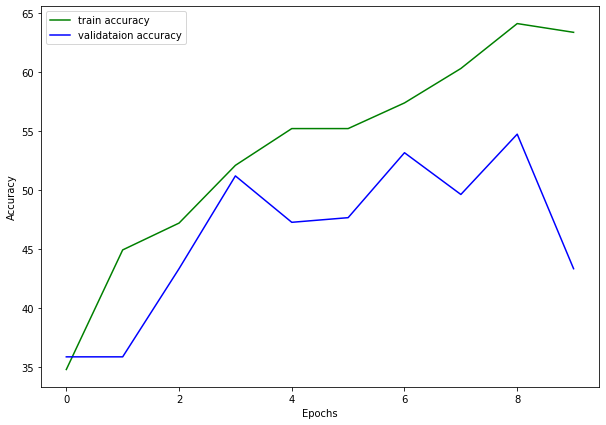

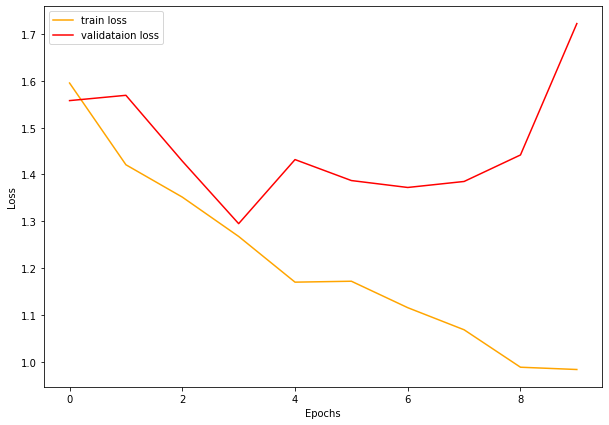

TRAINING COMPLETE


In [53]:
training_loop(mlp, criterion, optimizer, 10)

In [54]:
PATH = './garbage_mlp.pth'
torch.save(mlp.state_dict(), PATH)

In [55]:
mlp = MLP()
mlp.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [56]:
mlp.cuda()
test(mlp)

Accuracy of the network on the test images: 41 %
F1-score of the network on the test images: 0.3996581551456499


In [57]:
mlp.cuda()
class_accuracy(mlp)

Accuracy for class: metal is 65.8 %
Accuracy for class: trash is 20.0 %
Accuracy for class: paper is 63.8 %
Accuracy for class: glass is 45.5 %
Accuracy for class: plastic is 14.9 %
Accuracy for class: cardboard is 50.0 %


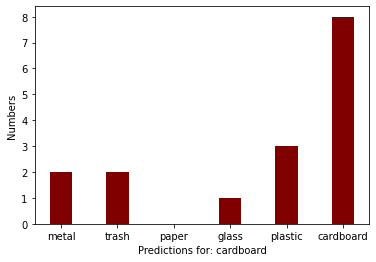

In [58]:
explore(mlp, 5)

In [59]:
del mlp
del MLP

Observations
1. We get a an overall accuracy of 41%. Trash and plastic do barely better than chance.
2. Looking at the training loss and validation loss curves, there is evidence of overfitting.

Conclusions
1. It's a bad idea to use MLP to handle images. MLPs use one perceptron per input so you get 224*224*3 + 1 = 150129 weight per neuron - can result in a very dense web of redundant and inefficient weights
2. MLPs on their own (without convolutional layers) cannot capture spatial structure

### Let's make VGG 11 from scratch
The models we tried above severely overfit, despite trying early stopping, weight decay, smaller learning rates to mitigate overfitting. Let's try the powerful VGG architecture.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x

In [39]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

In [40]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [41]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg = VGG(vgg11_layers, 6)
vgg = vgg.to(device)

In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

[INFO]: Epoch 1 of 10
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.66it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 144.72it/s]



Accuracy of class metal: 64.1025641025641
Accuracy of class trash: 32.72727272727273
Accuracy of class paper: 17.94871794871795
Accuracy of class glass: 29.032258064516128
Accuracy of class plastic: 83.33333333333333
Accuracy of class cardboard: 0.0


Training loss: 1.880, training acc: 28.119
Validation loss: 1.503, validation acc: 40.551
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 55.07it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 147.25it/s]



Accuracy of class metal: 69.23076923076923
Accuracy of class trash: 58.18181818181818
Accuracy of class paper: 38.46153846153846
Accuracy of class glass: 43.54838709677419
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 0.0


Training loss: 1.509, training acc: 40.099
Validation loss: 1.239, validation acc: 53.150
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.67it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.76it/s]



Accuracy of class metal: 61.53846153846154
Accuracy of class trash: 27.272727272727273
Accuracy of class paper: 33.333333333333336
Accuracy of class glass: 75.80645161290323
Accuracy of class plastic: 80.95238095238095
Accuracy of class cardboard: 0.0


Training loss: 1.449, training acc: 45.198
Validation loss: 1.202, validation acc: 52.362
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.59it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.98it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 96.36363636363636
Accuracy of class paper: 15.384615384615385
Accuracy of class glass: 80.64516129032258
Accuracy of class plastic: 45.23809523809524
Accuracy of class cardboard: 0.0


Training loss: 1.437, training acc: 44.010
Validation loss: 1.125, validation acc: 61.417
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.61it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 144.58it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 70.9090909090909
Accuracy of class paper: 51.282051282051285
Accuracy of class glass: 51.61290322580645
Accuracy of class plastic: 28.571428571428573
Accuracy of class cardboard: 0.0


Training loss: 1.322, training acc: 48.762
Validation loss: 1.241, validation acc: 51.575
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.43it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.00it/s]



Accuracy of class metal: 79.48717948717949
Accuracy of class trash: 38.18181818181818
Accuracy of class paper: 33.333333333333336
Accuracy of class glass: 85.48387096774194
Accuracy of class plastic: 83.33333333333333
Accuracy of class cardboard: 17.647058823529413


Training loss: 1.286, training acc: 51.634
Validation loss: 1.046, validation acc: 61.417
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.27it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.93it/s]



Accuracy of class metal: 71.7948717948718
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 35.8974358974359
Accuracy of class glass: 96.7741935483871
Accuracy of class plastic: 59.523809523809526
Accuracy of class cardboard: 0.0


Training loss: 1.257, training acc: 52.426
Validation loss: 1.039, validation acc: 64.173
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.25it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.13it/s]



Accuracy of class metal: 56.41025641025641
Accuracy of class trash: 87.27272727272727
Accuracy of class paper: 33.333333333333336
Accuracy of class glass: 88.70967741935483
Accuracy of class plastic: 47.61904761904762
Accuracy of class cardboard: 0.0


Training loss: 1.226, training acc: 53.812
Validation loss: 1.055, validation acc: 62.205
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.34it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.71it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 50.90909090909091
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 83.87096774193549
Accuracy of class plastic: 61.904761904761905
Accuracy of class cardboard: 0.0


Training loss: 1.200, training acc: 54.752
Validation loss: 0.932, validation acc: 61.811
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:09<00:00, 54.19it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.20it/s]




Accuracy of class metal: 79.48717948717949
Accuracy of class trash: 52.72727272727273
Accuracy of class paper: 43.58974358974359
Accuracy of class glass: 95.16129032258064
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 17.647058823529413


Training loss: 1.150, training acc: 56.980
Validation loss: 0.911, validation acc: 66.142
--------------------------------------------------


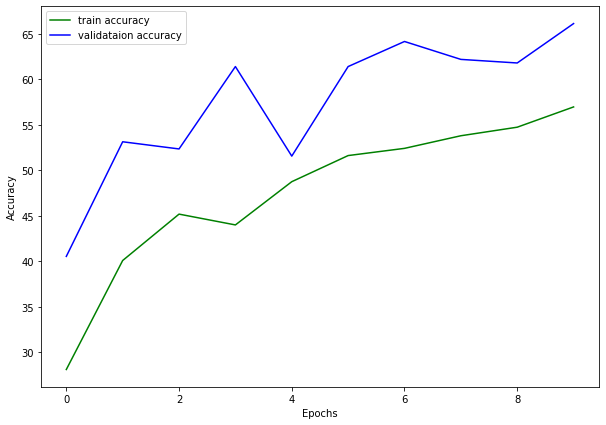

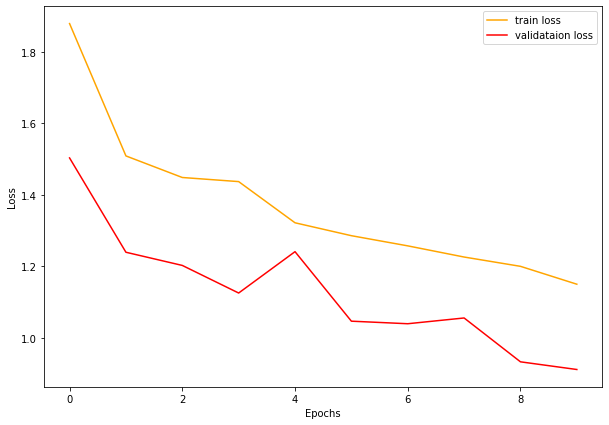

TRAINING COMPLETE


In [66]:
training_loop(vgg, criterion, optimizer, 10)

In [67]:
PATH = './garbage_mlp.pth'
torch.save(vgg.state_dict(), PATH)

In [68]:
vgg = VGG(vgg11_layers, 6)
vgg.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [69]:
vgg.cuda()
test(vgg)

Accuracy of the network on the test images: 57 %
F1-score of the network on the test images: 0.5603174851716965


In [70]:
vgg.cuda()
class_accuracy(vgg)

Accuracy for class: metal is 81.6 %
Accuracy for class: trash is 54.0 %
Accuracy for class: paper is 48.9 %
Accuracy for class: glass is 89.1 %
Accuracy for class: plastic is 51.1 %
Accuracy for class: cardboard is 31.2 %


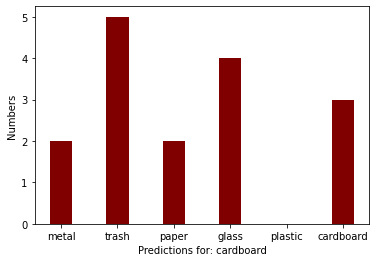

In [71]:
vgg.cuda()
explore(vgg, 5)

In [ ]:
del vgg

Hmmm, this model's training loss and validation loss curves look promising. Let's try with more epochs

Observations
1. We get a an overall accuracy of 57% - not as good as the other models at 10 epochs. 
2. Cardboard classification accuracy is low.
3. Looking at the training loss and validation loss curves, there is some promise, because there is no longer any evidence of overfitting.

Conclusions
1. We should try on more epochs, because, looking at the training loss and validation loss curves, the model shows potential to learn more.

### VGG11 at 15 epochs

[INFO]: Epoch 1 of 15
Training


100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 66.20it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.10it/s]



Accuracy of class metal: 76.92307692307692
Accuracy of class trash: 58.18181818181818
Accuracy of class paper: 46.15384615384615
Accuracy of class glass: 95.16129032258064
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 0.0


Training loss: 1.397, training acc: 54.703
Validation loss: 1.110, validation acc: 67.717
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.91it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.06it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 92.72727272727273
Accuracy of class paper: 46.15384615384615
Accuracy of class glass: 96.7741935483871
Accuracy of class plastic: 73.80952380952381
Accuracy of class cardboard: 0.0


Training loss: 1.105, training acc: 66.188
Validation loss: 0.959, validation acc: 75.591
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.71it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.80it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 65.45454545454545
Accuracy of class paper: 74.35897435897436
Accuracy of class glass: 88.70967741935483
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 17.647058823529413


Training loss: 0.998, training acc: 69.059
Validation loss: 0.917, validation acc: 74.016
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.58it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 149.34it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 98.18181818181819
Accuracy of class paper: 64.1025641025641
Accuracy of class glass: 91.93548387096774
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 11.764705882352942


Training loss: 0.936, training acc: 71.683
Validation loss: 0.851, validation acc: 77.953
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.28it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.53it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 90.9090909090909
Accuracy of class paper: 71.7948717948718
Accuracy of class glass: 95.16129032258064
Accuracy of class plastic: 66.66666666666667
Accuracy of class cardboard: 11.764705882352942


Training loss: 0.879, training acc: 75.248
Validation loss: 0.807, validation acc: 78.346
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.24it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.53it/s]



Accuracy of class metal: 76.92307692307692
Accuracy of class trash: 89.0909090909091
Accuracy of class paper: 41.02564102564103
Accuracy of class glass: 98.38709677419355
Accuracy of class plastic: 71.42857142857143
Accuracy of class cardboard: 17.647058823529413


Training loss: 0.835, training acc: 76.733
Validation loss: 0.806, validation acc: 74.409
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 65.10it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.45it/s]



Accuracy of class metal: 89.74358974358974
Accuracy of class trash: 85.45454545454545
Accuracy of class paper: 79.48717948717949
Accuracy of class glass: 85.48387096774194
Accuracy of class plastic: 76.19047619047619
Accuracy of class cardboard: 17.647058823529413


Training loss: 0.801, training acc: 76.832
Validation loss: 0.772, validation acc: 79.134
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.86it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 144.34it/s]



Accuracy of class metal: 79.48717948717949
Accuracy of class trash: 67.27272727272727
Accuracy of class paper: 41.02564102564103
Accuracy of class glass: 96.7741935483871
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 11.764705882352942


Training loss: 0.758, training acc: 78.564
Validation loss: 0.819, validation acc: 70.472
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.95it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.20it/s]



Accuracy of class metal: 74.35897435897436
Accuracy of class trash: 72.72727272727273
Accuracy of class paper: 61.53846153846154
Accuracy of class glass: 100.0
Accuracy of class plastic: 59.523809523809526
Accuracy of class cardboard: 29.41176470588235


Training loss: 0.730, training acc: 80.693
Validation loss: 0.792, validation acc: 72.835
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.96it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.70it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 83.63636363636364
Accuracy of class paper: 76.92307692307692
Accuracy of class glass: 100.0
Accuracy of class plastic: 73.80952380952381
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.713, training acc: 79.703
Validation loss: 0.665, validation acc: 81.496
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.89it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.19it/s]



Accuracy of class metal: 82.05128205128206
Accuracy of class trash: 96.36363636363636
Accuracy of class paper: 66.66666666666667
Accuracy of class glass: 90.3225806451613
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 29.41176470588235


Training loss: 0.657, training acc: 81.584
Validation loss: 0.673, validation acc: 80.709
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.79it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 144.98it/s]



Accuracy of class metal: 89.74358974358974
Accuracy of class trash: 69.0909090909091
Accuracy of class paper: 41.02564102564103
Accuracy of class glass: 96.7741935483871
Accuracy of class plastic: 88.0952380952381
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.640, training acc: 82.525
Validation loss: 0.730, validation acc: 75.591
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.71it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.65it/s]



Accuracy of class metal: 76.92307692307692
Accuracy of class trash: 85.45454545454545
Accuracy of class paper: 48.717948717948715
Accuracy of class glass: 98.38709677419355
Accuracy of class plastic: 69.04761904761905
Accuracy of class cardboard: 35.294117647058826


Training loss: 0.630, training acc: 83.020
Validation loss: 0.666, validation acc: 75.591
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.62it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.55it/s]



Accuracy of class metal: 89.74358974358974
Accuracy of class trash: 81.81818181818181
Accuracy of class paper: 64.1025641025641
Accuracy of class glass: 98.38709677419355
Accuracy of class plastic: 76.19047619047619
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.591, training acc: 84.307
Validation loss: 0.648, validation acc: 80.709
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training



100%|█████████████████████████████████████████████████████████████████████████████████| 505/505 [00:07<00:00, 64.77it/s]

Validation



100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 145.09it/s]




Accuracy of class metal: 89.74358974358974
Accuracy of class trash: 90.9090909090909
Accuracy of class paper: 66.66666666666667
Accuracy of class glass: 95.16129032258064
Accuracy of class plastic: 78.57142857142857
Accuracy of class cardboard: 41.1764705882353


Training loss: 0.549, training acc: 86.337
Validation loss: 0.595, validation acc: 82.677
--------------------------------------------------


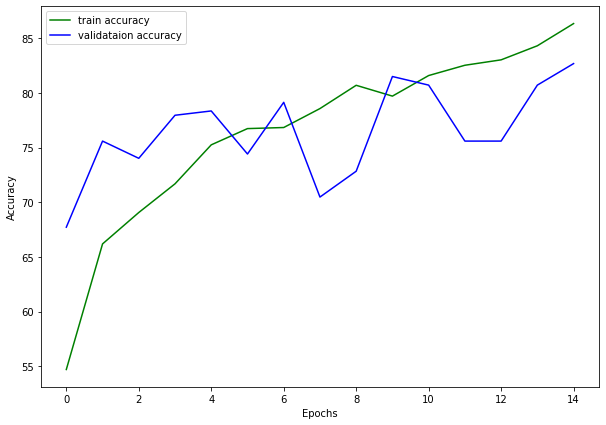

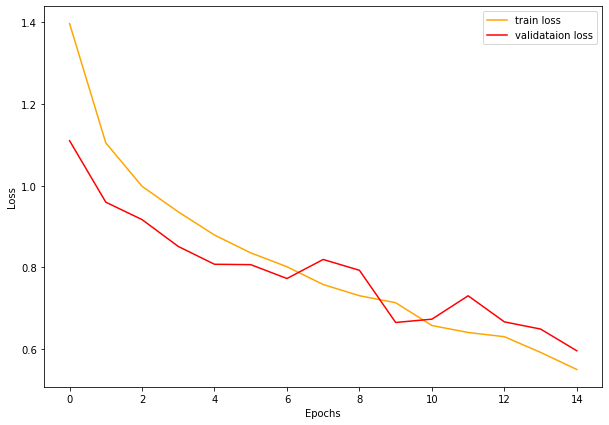

TRAINING COMPLETE


In [74]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg = VGG(vgg11_layers, 6)
vgg = vgg.to(device)
training_loop(vgg, criterion, optimizer, 15)


In [43]:
PATH = './garbage_mlp.pth'
torch.save(vgg.state_dict(), PATH)
vgg = VGG(vgg11_layers, 6)
vgg.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [99]:
vgg.cuda()
test(vgg)

Accuracy of the network on the test images: 84 %
F1-score of the network on the test images: 0.8486275822545579


In [106]:
del vgg
del VGG

Observations
1. We get a an overall accuracy of 84%. 
2. There is no overfitting

Conclusions
1. Perhaps a deeper model can learn more about the image than the sample model we were trying.

## Summary of model accuracy and F1-Score

![alt text](summary.png "Summary")

To conclude, I think the models were overfitting because the large number of features that were being fed into the linear layers resulted in a large number of redundant and inefficient weights with little idea of spatial structure. For context, the models before VGG-11 fed in 128*56*56 = 401408 features into the first linear layer and had an output dimension of 1296 unlike the VGG-11 whose first linear layer was fed 25088 features (16 times smaller) and had an output size of 4069./
Since such a large number of features was forced into such a small output size, the model is forced to learn a very compact representation of these features, that can help with training accuracy but not validatoin accuracy. 

## Improvements

### Model architecture 
The models had a hard time classifying cardboard images suggesting that there was a lack of discriminative features in the cardboard images. We need more powerful models to extract these features through: 
1. Increase the depth or width of the network by adding more convolutional layers or increasing the number of filters in existing layers. 
2. Using advanced architectures like ResNet 

### Data
1. Rescaling images - two issues to address are that the rescaling was too high and the aspect ratio was changed during rescaling. This caused some information loss. (this was measured separately using MSE to see the difference between original and rescaled image) - Try to use original images.
2. Gather more data - use existing datasets 
3. Apply data augmentation techniques during training, such as random cropping, rotation, scaling, or flipping of the input images => increases diversity of the data

### Finding optimal hyperparameters
1. Using Bayesain optimization to find the best set of hyperparameters

### Metrics
1. The f1-Score was quite similar to the accuracy in terms of magnitude. Even though we present the class-wise classification accuracy, we can add confusion matrices too. 